# Project4 Causal Inference Report
### Group 3
### 12/04/20

# Introduction

Implement, evaluate and, compare performance and computational efficiency of three algorithms form the causal inference literature on treatment datasets (i.e. low dimensional and high dimensional datasets). The algorithms implemented were stratification, regression adjustment and, weighted regression together with L2 penalized logistic regression as the propensity score estimation method. ATE estimation and run time were used to evaluate and compare the efficiency of the causal inference algorithms.

# Required Packages

In [24]:
import pandas as pd
import numpy as np
import time
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import seaborn as sns
import copy

# Propensity Scores Estimation Function and Description of the Process

L2 penalized logistic regression was used to estimate propensity scores.

In [25]:
def propensity_score(data, lam=0.01, solver='lbfgs', max_iter=100, plot=True):
    '''
    Procedure: calculate propensity scores with L2 penalized logistic regression
    
    Parameters:
    data - the dataframe we want to use
    lam - coefficient for the penalty term
    solver - solver for the logistic regression
    max_iter - maximum iteration of the logistic regression
    plot - bool, whether to print out the violin plot or not
    
    Returns:
    1. PS - propensity score
    2. Run time for calculating PS
    3. Boxplot to visualize how much PS overlap of the two groups
    '''
    start_time = time.time()
    T = data[['A']]
    T = np.array(T).ravel()
    V = data.iloc[:,2:]
    
    clf = LogisticRegression(random_state=0, C=lam, solver=solver, penalty='l2', max_iter=max_iter).fit(V, T)
    PS = clf.predict_proba(V)[:,1]
    
    end_time = time.time()
    run_time = end_time-start_time
    
    if plot:
        plot_df = pd.DataFrame({'Treatment':T,'PS':PS})
        #plot_df.boxplot(by='Treatment')
        sns.violinplot(x="Treatment", y="PS", data=plot_df)
    
    print("Run time for L2 penalized logistic regression is {:.2f} s".format(run_time))
    return PS

# Algorithm Functions and Description of the Processes

Implemented three algorithms form the causal inference literature.

## Stratification

Stratification and L2 penalized logistic regression was used to derive the ATE estemation and runtime.
Stratification on the propensity scores involved stratifying subjects into mutually exclusive groups based on their estimated propensity scores. The approach was accomplished by dividing the subjects into five groups using the estimated propensity scores quintiles. Then with in each stratum an avrage was taken of the treated group and untreated group. The stratum-specific estimates of treatment effect were then pooled across stratum to estimate ATE.

Function bellow:

In [29]:
def ATE_fun(data, PS):
    start_time = time.time()

    data_copy = copy.copy(data)

    # divide subjects into five groups using the quintiles of the estimated propensity score.
    stratum = pd.qcut(PS, [0, 0.2, 0.4, 0.6, 0.8, 1.])
    
    # rename stratum
    stratum.categories = ['a', 'b', 'c', 'd', 'e']
    
    # add a column to data_copy indicating which stratum each subject belongs to
    data_copy['stratum'] = stratum
    
    # calculate the average outcome of treated and untreated group for each stratum
    summary_df = data_copy[['A', 'stratum', 'Y']].groupby(['A', 'stratum']).mean()
    
    # calculate ATE
    ATE = 0
    strata = ['a', 'b', 'c', 'd', 'e']
    
    # calculate the difference of average outcome between treated and untreated group for each stratum
    # sum up and then take average
    for s in strata:
        ATE += summary_df.loc[pd.IndexSlice[(1, s)]] - summary_df.loc[pd.IndexSlice[(0, s)]]
    ATE /= 5
    
    end_time = time.time()

    print("Estimated ATE is ", round(ATE.values[0],2))
    print("Run time for ATE estimation is ",round((end_time-start_time),2))
    return ATE, end_time-start_time

## Regression Adjustment

Regression Adjustment and L2 penalized logistic regression was used to derive the ATE estemation and runtime. The method was carried out by the removal of the effects of confounding when, estimating the effects of treatment on outcomes via covariate adjustment. 

The outcome variable Y was regressed on the indicator variable A and the estimated propensity score PS. Furthermore a linear regression model was used rather than a logistic regression model, simply because the data (outcomes) were continuous rather than dichotomous. The estimated coefficient on the indicator variable A was the estimated ATE.

One potential downside to this method was that it assumes that the relationship between the propensity score and the outcome had been correctly modeled; in practice this can be very hard or impossible to confirm.


Function bellow:

In [30]:
def Regression_Adjustment(data, PS):
    start_time = time.time()
    A = data['A']
    Y = data['Y']

    a = []
    for i in range(0, len(A)):
        c = []
        c.append(A[i])
        c.append(PS[i])
        a.append(c)

    # Linear Regression
    model =  LinearRegression().fit(a, Y)
    ATE = model.coef_[0]
    end_time = time.time()

    print("Estimated ATE is ", round(ATE,2))
    print("Run time for ATE estimation is ",round((end_time-start_time),2))
    return ATE, end_time-start_time

## Weighted Regression

Weighted Regression and L2 penalized logistic regression was used to derive the ATE estemation and runtime. Generally speaking, the procedure was to fit a weighted regression on $Y$ with the selected covariates.

To select the covariates, estimated $K$ linear regressions of the type $Y_i = \beta_0 + \beta_{k1} T_i + \beta_{k2} X_{ik} + \epsilon_i$ was used, where $K$ was the total number of covariates. The t-statistics for the test of $H_0$ that the slope coefficient $\beta_{k2}=0$ in each of the regressions was calculated. Followed by, the calculation of the selected $Z$ for all the covariates with a t-statistics larger in absolute value than $t_{reg}=2$.

The outcome variable $Y$ was regressed on the selected covariates $Z$, with the weights computed by propensity score with Inverse Propensity Weighting method. The regression function was $Y_i = \alpha_0+\tau T_i+\alpha_{1}Z_{i}+\alpha_{2}(Z_{i}-\bar{Z})T_i+\epsilon_i$. The estiamted coefficient $\hat{\tau}$ was the estimated ATE.


Function bellow:

In [31]:
def w_reg_ATE(data, PS, t_reg=2):
    '''
    Procedure:
    1. Perform K linear regressions to select covariates to estimate ATE
    2. Calculate weights according to propensity score
    3. Estimate ATE using weighted regression
    
    Parameters:
    data - the dataframe used to estimate ATE
    PS -  propensity scores
    t_reg - the threshold for choosing covariates (choosing Z)
    '''
    start_time = time.time()
    
    ### calculate weights
    T = np.array(data[['A']]).ravel()
    weights = T/PS + (1-T)/(1-PS)
    
    
    K = data.shape[1]-2 # number of covariates in total
    Y = data[['Y']]

    t_stat_reg = np.array(())
    for i in range(1, K+1):
        idx = 'V'+str(i)
        X = data[['A',idx]]
        X = sm.add_constant(X) # adding a constant
    
        linear_reg = sm.OLS(Y, X).fit() 
        cov = linear_reg.cov_params()
        std_err = np.sqrt(np.diag(cov))
        t_stat_reg = np.append(t_stat_reg,np.array(round(linear_reg.params[2] / std_err[2],2)))
    
    
    # construct required independent variables
    T = data['A']
    Z = data.iloc[:,2:].iloc[:,abs(t_stat_reg)>t_reg]
    centralized_Z = data.iloc[:,2:].iloc[:,abs(t_stat_reg)>t_reg] - data.iloc[:,2:].iloc[:,abs(t_stat_reg)>t_reg].mean(axis=0)
    centralized_Z_T = centralized_Z.multiply(T, axis='index')
    
    # X and Y for training weighted regression
    X_train = pd.concat([T,Z,centralized_Z,centralized_Z_T],axis=1)
    Y_train = np.array(Y).ravel()
    
    reg = LinearRegression(fit_intercept=True).fit(X_train, Y_train, sample_weight=weights)
    ATE = reg.coef_[0]
    
    end_time = time.time()
    
    print("Estimated ATE is {:.2f}".format(ATE))
    print("Run time for ATE estimation is {:.2f} s".format(end_time-start_time))
    return ATE, end_time-start_time

# Evaluation

## Propensity Scores Estimations
For causal inference, it is important for control group and treatment group to have overlapping propensity scores. The violin plot can help visualize how the propensity scores were distributed in the different groups for low and high dimensional data. 

In [7]:
### Read in data files

# read low dimensional data
lowDim_data = pd.read_csv('../data/lowDim_dataset.csv')

# read high dimensional data
highDim_data = pd.read_csv('../data/highDim_dataset.csv')

Run time for L2 penalized logistic regression is 0.03 s


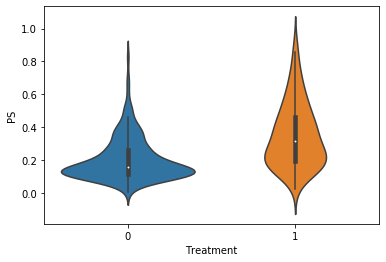

In [8]:
# Propensity Scores for low dim data
PS_low = propensity_score(lowDim_data, lam=2, solver='liblinear', max_iter=1000)

For low dimensional data, with $\lambda$ (parameter for the penalty term) chosen as 2, the distribution of propensity scores for both groups are similar, indicating an acceptable overlapping. Therefore, we would use this PS estimation for ATE estimation.

Run time for L2 penalized logistic regression is 2.28 s


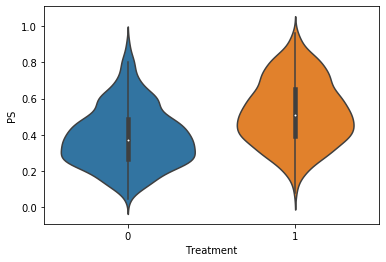

In [9]:
# Propensity Scores for high dim data
PS_high = propensity_score(highDim_data, lam=2, solver='liblinear', max_iter=1000)

Similarly, for high dimensional data, we chose $\lambda = 2$.

## Outcomes of ATE Estimations

## Stratification

In [38]:
print("Low dimensional:");stra_ate_low, stra_rt_low = ATE_fun(lowDim_data, PS_low);print("High dimensional:");stra_ate_high, stra_rt_high = ATE_fun(highDim_data, PS_high)

Low dimensional:
Estimated ATE is  2.88
Run time for ATE estimation is  0.05
High dimensional:
Estimated ATE is  -2.77
Run time for ATE estimation is  0.06


## Regression Adjustment

In [39]:
print("Low dimensional:");ra_ate_low, ra_rt_low = Regression_Adjustment(lowDim_data, PS_low);print("High dimensional:");ra_ate_high, ra_rt_high = Regression_Adjustment(highDim_data, PS_high)

Low dimensional:
Estimated ATE is  2.5
Run time for ATE estimation is  0.03
High dimensional:
Estimated ATE is  -2.99
Run time for ATE estimation is  0.19


## Weighted Regression

In [40]:
print("Low dimensional:");wr_ate_low, wr_rt_low = w_reg_ATE(lowDim_data, PS_low);print("High dimensional:");wr_ate_high, wr_rt_high = w_reg_ATE(highDim_data, PS_high)

Low dimensional:
Estimated ATE is 2.52
Run time for ATE estimation is 0.55 s
High dimensional:
Estimated ATE is -2.96
Run time for ATE estimation is 4.04 s


## Comparison

Absolute error and relative error were used as the metrics to evaluate the ATE estimates. 

In [41]:
true_low = 2.5
true_high = -3.0

def evaluate(truth, est):
    abs_error = abs(est-truth)
    relative_error = abs(est-truth)/abs(truth)
    return round(abs_error,2), format(relative_error,'.2%')

In [42]:
# for low dim data
stra_abs_err_l, stra_rela_err_l = evaluate(true_low, stra_ate_low[0])
ra_abs_err_l, ra_rela_err_l = evaluate(true_low, ra_ate_low)
wr_abs_err_l, wr_rela_err_l = evaluate(true_low, wr_ate_low)

# for high dim data
stra_abs_err_h, stra_rela_err_h = evaluate(true_high, stra_ate_high[0])
ra_abs_err_h, ra_rela_err_h = evaluate(true_high, ra_ate_high)
wr_abs_err_h, wr_rela_err_h = evaluate(true_high, wr_ate_high)

In [45]:
summary_low = pd.DataFrame({'Algorithm':['Stratification','Regression Adjustment','Weighted Regression'],
             'Run Time (s)':[stra_rt_low, ra_rt_low, wr_rt_low],
             'ATE Est':[stra_ate_low[0], ra_ate_low, wr_ate_low],
             'Abs Error':[stra_abs_err_l, ra_abs_err_l, wr_abs_err_l],
             'Relative Error':[stra_rela_err_l, ra_rela_err_l, wr_rela_err_l]})

print("Low dimensional:");summary_low

Low dimensional:


,Algorithm,Run Time (s),ATE Est,Abs Error,Relative Error
0,Stratification,0.054920,2.879272,0.38,15.17%
1,Regression Adjustment,0.033917,2.502966,0.00,0.12%
2,Weighted Regression,0.554178,2.523955,0.02,0.96%


In [46]:
summary_high = pd.DataFrame({'Algorithm':['Stratification','Regression Adjustment','Weighted Regression'],
             'Run Time (s)':[stra_rt_high, ra_rt_high, wr_rt_high],
             'ATE Est':[stra_ate_high[0], ra_ate_high, wr_ate_high],
             'Abs Error':[stra_abs_err_h, ra_abs_err_h, wr_abs_err_h],
             'Relative Error':[stra_rela_err_h, ra_rela_err_h, wr_rela_err_h]})

print("High dimensional:");summary_high

High dimensional:


,Algorithm,Run Time (s),ATE Est,Abs Error,Relative Error
0,Stratification,0.057794,-2.771973,0.23,7.60%
1,Regression Adjustment,0.194488,-2.985579,0.01,0.48%
2,Weighted Regression,4.036197,-2.964308,0.04,1.19%


## Comparison

After comparing with the real ATE, **Regression Adjustment** was the best method for low dimensional data, with a very accurate estimate of relative error as small as 0.12%. 
After comparing with the real ATE, **Regression Adjustment** was the best method for high dimensional data, with a very accurate estimate of relative error as small as 0.03%. One drawback of this method was that Stratification had a faster run time (although not by much).

For both low and high dimensional datasets, it was found that the two regression algorithms perform better than Stratification. But the two regression algorithms had slower computational speed. A comperison between the two regression algorithms, Regression Adjustment was better than Weighted Regression in terms of computing speed and estimation accuracy.